In [1]:
# Standard libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_lib import loadmat
from matlab.matlab_yaro_lib import matstruct2dict, merge_dicts, read_neuro_perf, read_lick, read_paw, read_whisk
from qt_wrapper import gui_fname, gui_fpath
from signal_lib import trunc_idx, resample

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/TNU2019-Project/src/lib


# Neuronal and Behavioural Data

All Behavioural data will be truncated and resampled in order to match the neuronal data

In [6]:
TARGET_RANGE = [0, 8] # Seconds goal
TARGET_FREQ = 20 # Hz
TARGET_NTIMES = int((TARGET_RANGE[1]-TARGET_RANGE[0])*TARGET_FREQ) + 1
TARGET_TIMES = np.linspace(TARGET_RANGE[0], TARGET_RANGE[1], TARGET_NTIMES)
print("Target timesteps witin", TARGET_RANGE, "sec. Total length", TARGET_NTIMES)

Target timesteps witin [0, 8] sec. Total length 161


Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour
Loaded neuronal data with (nTrials, nTimes, nChannels)= (590, 201, 12)
Trial number by type: [('iGO', 280), ('iNOGO', 238), ('iFA', 56), ('iMISS', 16)]


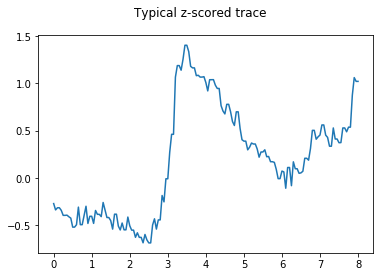

In [7]:
# You can use gui to select path
# data_path = gui_fpath("Select one more data directory, or cancel", './')
data_path = "../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour"

# Read LVM file from command line
data, behaviour = read_neuro_perf(data_path)

# Get parameters
TRIAL_TYPES = ['iGO', 'iNOGO', 'iFA', 'iMISS']
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)
print("Trial number by type:", [(k, len(behaviour[k])) for k in TRIAL_TYPES])

if nTimes < TARGET_NTIMES:
    raise ValueError("Number of time steps in the file ",nTimes,"is less than expected", TARGET_NTIMES)
    
# Crop to desired timesteps
nTimes = TARGET_NTIMES
data = data[:, :TARGET_NTIMES, :]

# Z-scoring separately for each channel
zscore = lambda x : (x - np.mean(x))/np.std(x)
for iChannel in range(nChannels):
    data[:,:,iChannel] = zscore(data[:,:,iChannel])
    
plt.figure()
plt.suptitle('Typical z-scored trace')
plt.plot(TARGET_TIMES, data[0,:,3])
plt.show()

# Lick

**lick_traces**
- 2D (nTimes, nTrials)
- Freq 100Hz
- Crop to 8s (real datafile is longer but data after 8s is bad and also not interesting)
- Binary threshold data as lick if it is outside [bot_th, top_th].
- Downsample data while convolving it with broad gaussian kernel
  
**TODO**
- Check with Yaro if I have understood him correctly about thresholding
- Pick paradigm for selecting gaussian width

In [8]:
#m_path = gui_fpath("Select data directory", './')
m_path = '../../data/raw/mtp_13_2017_03_22_a/lick'
f_lick = read_lick(m_path)

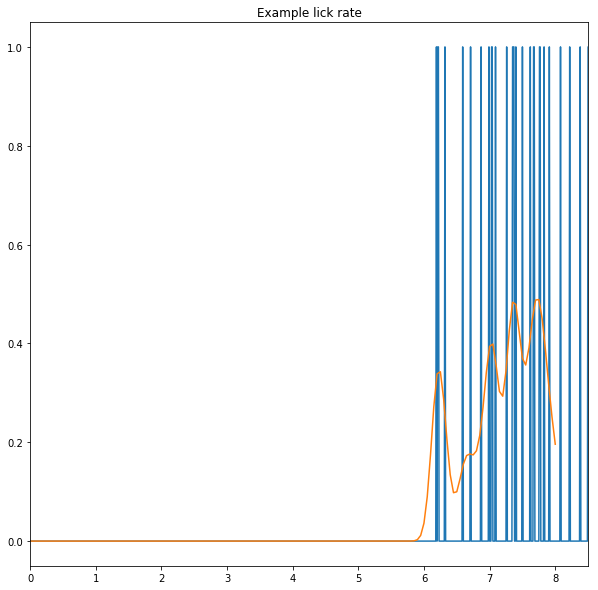

In [9]:
param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : (2.0/TARGET_FREQ)**2}
l,r = trunc_idx(f_lick['tLicks'], 0, 8)
tLicksTrunc = f_lick['tLicks'][l:r]


data_lick = np.zeros((nTrials, TARGET_NTIMES))
keymap_lick = {
    'iGO'    : 'licks_go',
    'iNOGO'  : 'licks_nogo',
    'iFA'    : 'licks_FA',
    'iMISS'  : 'licks_miss'}

for k, v in keymap_lick.items():
    if len(f_lick[v]) > 0:
        # Truncate data
        lick_trunc = f_lick[v][l:r]
        
        # Resample and stitch all trials back together into one 2D matrix
        # Note MATLAB index in behaviour is +1
        for iSubTrial, iTrialMATLAB in enumerate(behaviour[k]):
            data_lick[iTrialMATLAB-1] = resample(tLicksTrunc, lick_trunc[:, iSubTrial], TARGET_TIMES, param_resample)
        
# Normalizing
data_lick /= np.max(data_lick)

# Plot before
plt.figure(figsize=(10,10))
plt.plot(f_lick['tLicks'], f_lick['licks_go'][:, 10])

# Plot after
plt.plot(TARGET_TIMES, data_lick[behaviour['iGO'][10]-1])
plt.title("Example lick rate")
plt.xlim([0, 8.5])
plt.show()

# Paw

**Trials.m**: 
(iTrial vs iTime (0-6s, sometimes 7Hz (If step=64), else (>250) 30Hz) )

**TODO**
- Improve baseline estimation, perhaps compute low end distribution peak instead of mean, as mean is too high

In [10]:
#m_name = gui_fname("Select data directory", './', filter="Matlab Files (*.m, *.mat)")
m_name = '../../data/raw/mtp_13_2017_03_22_a/paw/trials.mat'
f_paw = read_paw(m_name)

print("Reading file", m_name)
print("Shape of raw paw trials", f_paw['trialsPaw'].shape)

Reading file ../../data/raw/mtp_13_2017_03_22_a/paw/trials.mat
Shape of raw paw trials (590, 271)


Baseline estimated to be at 0.012570515790489078
Shape of resampled paw trials (590, 161)


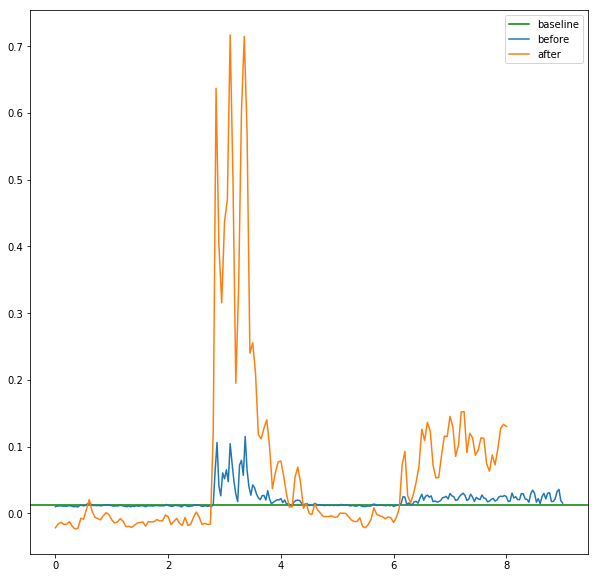

In [11]:
# Estimate baseline
#mle = np.nanmean(f_paw['trialsPaw'])
hist_v, hist_t = np.histogram(f_paw['trialsPaw'].flatten(), bins='auto')
mle = hist_t[np.argmax(hist_v)]
print("Baseline estimated to be at", mle)

# 1) Subtract baseline and rescale
data_paw = f_paw['trialsPaw'] - mle
data_paw[np.isnan(data_paw)] = 0
#data_paw /= np.max(data_paw)

# Truncate
l,r = trunc_idx(f_paw['tPaw'], 0, 8)
paw_times_tmp = f_paw['tPaw'][l:r]
data_paw = data_paw[:, l:r]

# Resample
nTrials = data_paw.shape[0]

if f_paw['freqPaw'] < TARGET_FREQ:
    param_resample = {'method' : 'interpolative', 'kind' : 'cubic'}
else:
    param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : (0.5/TARGET_FREQ)**2}
data_paw = np.array([resample(paw_times_tmp, data_paw[iTrial], TARGET_TIMES, param_resample) for iTrial in range(nTrials)])

# Normalize
data_paw /= np.max(data_paw)

print("Shape of resampled paw trials", data_paw.shape)

# Plot after
plt.figure(figsize=(10,10))
plt.axhline(y=mle, xmin=0, xmax=8, label='baseline',color='g')
plt.plot(f_paw['tPaw'], f_paw['trialsPaw'][0], label='before')
plt.plot(TARGET_TIMES, data_paw[0], label='after')
plt.legend()
plt.show()

# Whisk

**TODO**
- Velocity Data does not look informative - think of better metrics
- Ask Yaro / Read his email on how data was obtained - think further
- BUG: Some files do not open using scipy.loadmat() - do they have errors inside?
- BUG: Some files have unexpected number of timesteps - is sampling rate Yaro told me not precise?

In [12]:
#m_path = gui_fpath("Select data directory", './')
m_path = '../../data/raw/mtp_13_2017_03_22_a/whisk'
f_whisk = read_whisk(m_path)

**NOTE** There appears to be some bug in the whisking data, so we will leave the data out for now

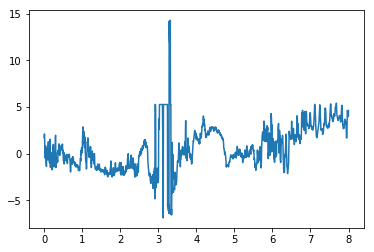

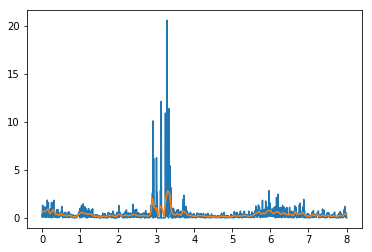

In [82]:
# # Plot before
# plt.figure()
# plt.plot(f_whisk['tWhisk'], f_whisk['whiskAngle'][:, 0])
# plt.show()

# # 1) Subtract baseline
# nTrials = f_whisk['whiskAngle'].shape[1]
# f_whisk['whiskAngle'] -= np.nanmean(f_whisk['whiskAngle'])
# f_whisk['whiskAngle'][np.isnan(f_whisk['whiskAngle'])] = 0
# f_whisk['whiskAbsVelocity'] = np.vstack((np.abs(f_whisk['whiskAngle'][1:] - f_whisk['whiskAngle'][:-1]), np.zeros(nTrials)))

# # Truncate
# l,r = trunc_idx(f_whisk['tWhisk'], 0, 8)
# f_whisk['tWhisk']     = f_whisk['tWhisk'][l:r]
# f_whisk['whiskAngle'] = f_whisk['whiskAngle'][l:r]
# f_whisk['whiskAbsVelocity'] = f_whisk['whiskAbsVelocity'][l:r]

# # Plot after
# plt.figure()
# plt.plot(f_whisk['tWhisk'], f_whisk['whiskAbsVelocity'][:,0])

# # Resample
# param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : (4/200)**2}
# f_whisk['whiskAbsVelocity'] = np.array([resample(f_whisk['tWhisk'], f_whisk['whiskAbsVelocity'][:, iTrial], TARGET_TIMES, param_resample) for iTrial in range(nTrials)])
        

# plt.plot(TARGET_TIMES, f_whisk['whiskAbsVelocity'][0])
# plt.show()

# Packaging

The aim is to collect all neuronal data and resampled behavioural data into a single structure that can be used later in matlab

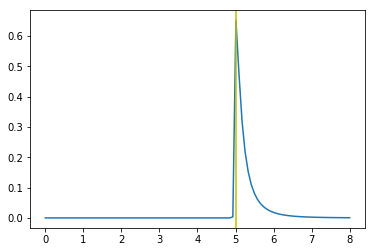

In [13]:
# Construct and test log-normal broadening for peaked datapoints
def lognorm(x, mu, s2, L):
    lnorm = lambda x, s2 : np.exp( -np.log(x)**2/2/s2 ) / x / np.sqrt(2*np.pi*s2)    
    
    x_eff = (x - mu)/L + np.exp(-s2)
    feasible = x_eff > 0
    rez = np.zeros(x.shape)
    rez[feasible] = lnorm(x_eff[feasible], s2)
    return rez

x = np.linspace(0, 8, 100)
plt.figure()
plt.plot(x, lognorm(x, 5, 1, 0.2))
plt.axvline(x=5,ymin=0,ymax=1, color='y')
plt.show()

Construct behavioural signal data

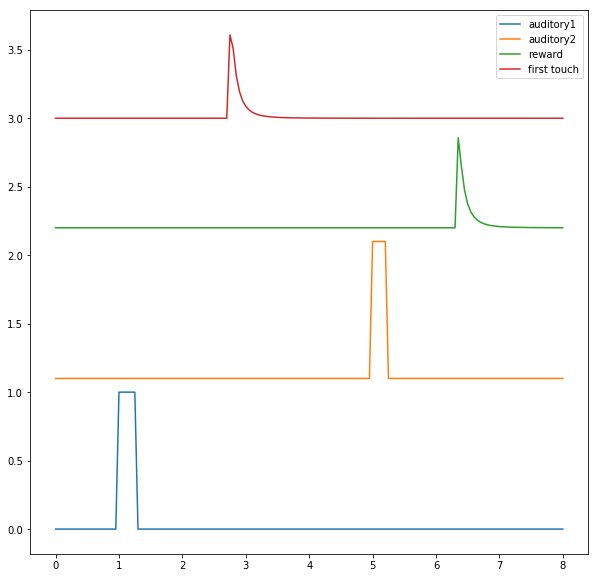

In [14]:
# Construct auditory cue channels
auditoryCue1 = np.zeros((nTrials, TARGET_NTIMES))
auditoryCue2 = np.zeros((nTrials, TARGET_NTIMES))
cue1_l, cue1_r = trunc_idx(TARGET_TIMES, 1, 1.25)
cue2_l, cue2_r = trunc_idx(TARGET_TIMES, 5, 5.2)
auditoryCue1[:, cue1_l:cue1_r] = 1
auditoryCue2[:, cue2_l:cue2_r] = 1

# Construct reward channel
rewardTrace = np.zeros((nTrials, TARGET_NTIMES))
for i in range(nTrials):
    if not np.isnan(f_lick['reward_time'][i]):
        rewardTrace[i] = lognorm(TARGET_TIMES, f_lick['reward_time'][i], 1.0, 0.1)

# Construct first touch trace
firstTouchTrace = np.array([lognorm(TARGET_TIMES, mu/1000, 1.0, 0.1) for mu in f_whisk['firstTouch']])

plt.figure(figsize=(10,10))
plt.plot(TARGET_TIMES, auditoryCue1[0], label='auditory1')
plt.plot(TARGET_TIMES, auditoryCue2[0]+1.1, label='auditory2')
plt.plot(TARGET_TIMES, rewardTrace[0]+2.2, label='reward')
plt.plot(TARGET_TIMES, firstTouchTrace[0]+3.0, label='first touch')
plt.legend();

Save data to HDF5

In [16]:
save_path = gui_fpath("Select data directory", './')

arrs = [
    data,
    np.expand_dims(data_lick, axis=2),
    np.expand_dims(data_paw, axis=2),
    np.expand_dims(auditoryCue1, axis=2),
    np.expand_dims(auditoryCue2, axis=2),
    np.expand_dims(rewardTrace, axis=2),
    np.expand_dims(firstTouchTrace, axis=2)]

dataCat = np.concatenate(arrs, axis=2)
print(dataCat.shape)

h5f = h5py.File(os.path.join(save_path, 'packageNeuroBehavioural.h5'), "w")
h5f['megadata'] = dataCat
h5f.close()

# for ttype in TRIAL_TYPES:
#     trials_idx = behaviour[ttype]-1  # NOTE matlab index starts from 1
#     arrs = [
#         data[trials_idx],
#         np.expand_dims(data_lick[ttype], axis=2),
#         np.expand_dims(data_paw[trials_idx], axis=2),
#         auditoryCue1[trials_idx],
#         auditoryCue2[trials_idx],
#         rewardTrace[trials_idx],
#         firstTouchTrace[trials_idx]]
    
#     dataCat = np.concatenate(arrs, axis=2)
#     print(dataCat.shape)
    
#     h5f = h5py.File(os.path.join(save_path, 'datacat_'+ttype+'.h5'), "w")
#     h5f['megadata'] = dataCat
#     h5f.close()

(590, 161, 18)
